# Example notebook

In [26]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,"

In [81]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "3"

%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid


rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

data_folder = 'data/cubicasa5k/'
data_file = 'test.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)
# Setup Model
model = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()
print("Model loaded.")

Model loaded.


In [88]:
normal_set = FloorplanSVG(data_folder, 'test.txt', augmentations=Compose([DictToTensor()]))
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)

In [80]:
split = [21, 12, 11]
from floortrans.metrics import get_evaluation_tensors, runningScore
from tqdm import tqdm
with torch.no_grad():
        for count, val in tqdm(enumerate(data_loader), total=len(data_loader), ncols=80, leave=False):
            #logger.info(count)
            things = get_evaluation_tensors(val, model, split, rotate=True)


RuntimeError: start (0) + length (21) exceeds dimension size (2).

In [93]:
val = next(data_iter)

In [98]:
print(val)

{'image': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.000

In [94]:
label = (val["label"])

In [97]:
print(label)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])


In [85]:
heatmaps_val, rooms_val, icons_val = split_validation(label, img_size, split)

RuntimeError: start (0) + length (21) exceeds dimension size (2).

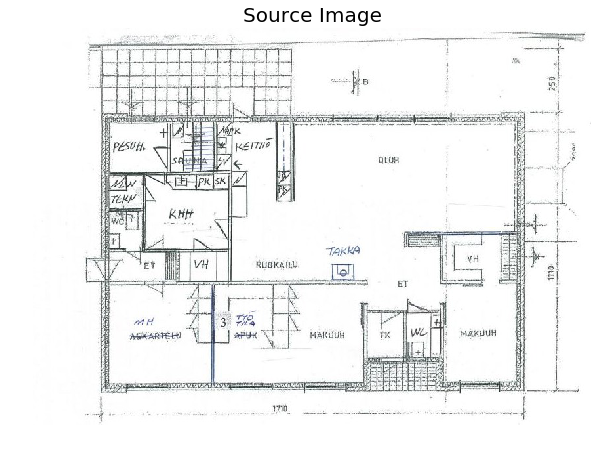

/high_quality_architectural/2530/


In [60]:
val = next(data_iter)
junctions = val['heatmaps']
folder = val['folder'][0]
image = val['image'].cuda()
label = val['label']
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
plt.figure(figsize=(10,10))
plt.title('Source Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()
print(folder)

## The SVG floorplan
If the floorplan includes two floors the other floor might not be visible, but it will be parsed never the less.

In [22]:
print(val["image"].shape)

torch.Size([1, 3, 366, 918])


In [66]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= data_folder+folder+"model.svg", width=800)

## Parsed labels

In [101]:
print(label_np.shape)

(2, 605, 851)


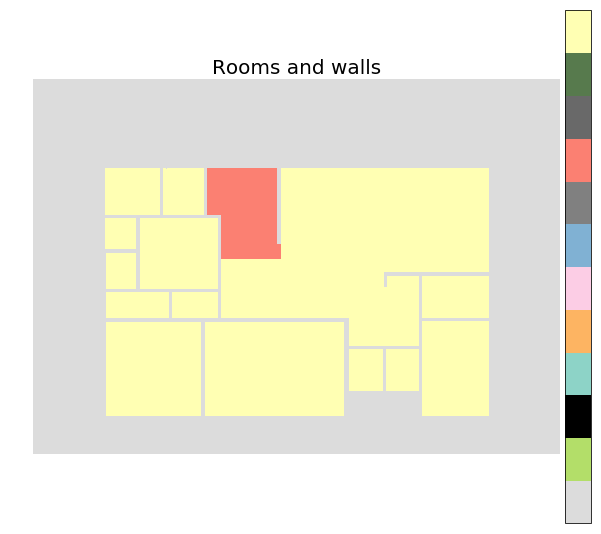

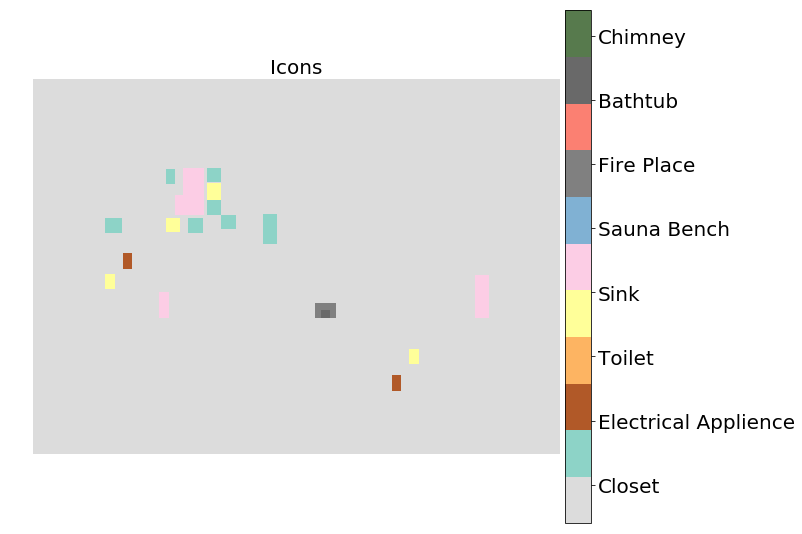

point_dict {0: [], 1: [], 2: [[tensor([396]), tensor([265])], [tensor([569]), tensor([335])]], 3: [], 4: [[tensor([509]), tensor([549])], [tensor([743]), tensor([549])]], 5: [[tensor([111]), tensor([549])], [tensor([621]), tensor([549])]], 6: [[tensor([111]), tensor([136])], [tensor([569]), tensor([314])]], 7: [[tensor([743]), tensor([136])], [tensor([506]), tensor([388])], [tensor([301]), tensor([222])]], 8: [[tensor([278]), tensor([136])], [tensor([207]), tensor([136])], [tensor([396]), tensor([136])], [tensor([274]), tensor([388])], [tensor([169]), tensor([222])], [tensor([222]), tensor([340])], [tensor([625]), tensor([314])], [tensor([567]), tensor([432])]], 9: [[tensor([621]), tensor([508])], [tensor([743]), tensor([314])], [tensor([743]), tensor([388])], [tensor([301]), tensor([340])], [tensor([169]), tensor([276])], [tensor([625]), tensor([432])]], 10: [[tensor([274]), tensor([549])], [tensor([567]), tensor([508])], [tensor([301]), tensor([388])], [tensor([222]), tensor([388])],

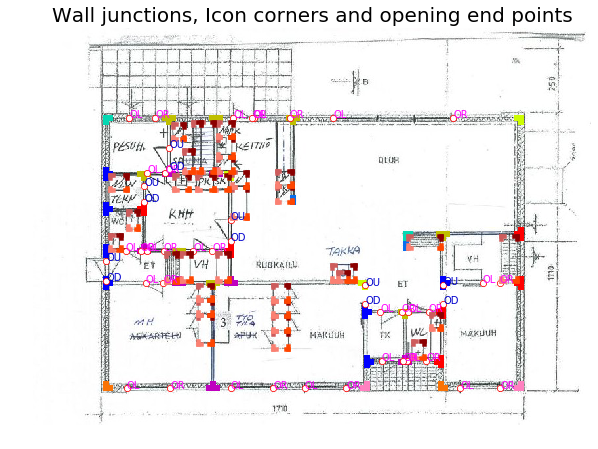

In [104]:
label_np = label.data.numpy()[0]
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Rooms and walls', fontsize=20)
ax.axis('off')
n_rooms = 3
rseg = ax.imshow(label_np[0], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Icons', fontsize=20)
ax.axis('off')
n_icons = 11
iseg = ax.imshow(label_np[1], cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()


plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Wall junctions, Icon corners and opening end points', fontsize=20)
ax.axis('off')
ax.imshow(np_img)
h, w, _ = np_img.shape
draw_junction_from_dict(junctions, w, h, size=0.3, fontsize=10)
plt.show()

## Networks prediction for the segmentation

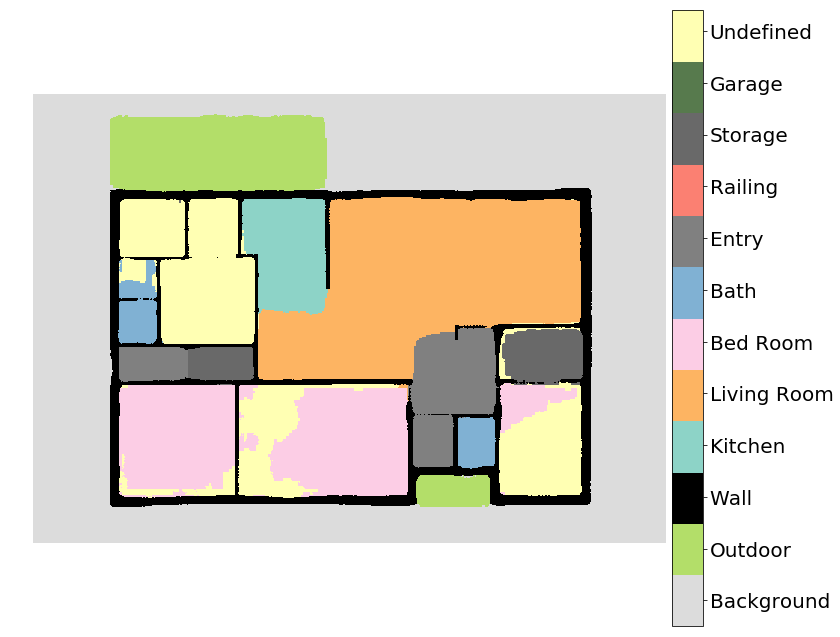

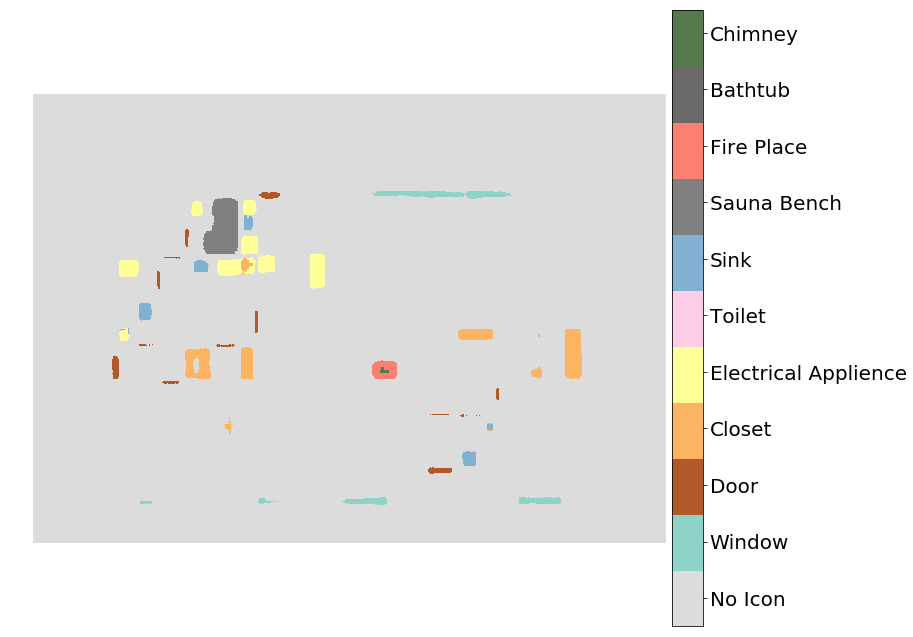

In [68]:
with torch.no_grad():
    height = label_np.shape[1]
    width = label_np.shape[2]
    img_size = (height, width)
    
    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        forward, back = r
        # We rotate first the image
        rot_image = rot(image, 'tensor', forward)
        pred = model(rot_image)
        # We rotate prediction back
        pred = rot(pred, 'tensor', back)
        # We fix heatmaps
        pred = rot(pred, 'points', back)
        # We make sure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # We add the prediction to output
        prediction[i] = pred[0]

prediction = torch.mean(prediction, 0, True)
rooms_label = label_np[0]
icons_label = label_np[1]

rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(rooms_pred, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(icons_pred, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

In [69]:
prediction.shape

torch.Size([1, 44, 605, 851])

## Post-processed polygons

wall Lines
[(0, 37, 2), (1, 25, 2), (18, 3, 2), (11, 4, 2), (5, 24, 2), (24, 6, 2), (9, 6, 2), (36, 7, 2), (32, 7, 2), (41, 8, 2), (8, 32, 2), (26, 9, 2), (10, 20, 2), (10, 40, 2), (11, 21, 2), (12, 22, 2), (31, 12, 2), (13, 27, 2), (18, 13, 2), (30, 14, 2), (15, 25, 2), (15, 28, 2), (16, 33, 2), (16, 23, 2), (40, 16, 2), (17, 18, 2), (17, 31, 2), (20, 17, 2), (19, 30, 2), (19, 32, 2), (35, 19, 2), (20, 33, 2), (21, 27, 2), (21, 42, 2), (22, 30, 2), (29, 22, 2), (23, 29, 2), (39, 23, 2), (27, 24, 2), (25, 26, 2), (28, 26, 2), (36, 28, 2), (38, 29, 2), (34, 35, 2), (41, 34, 2), (37, 36, 2), (39, 38, 2), (38, 41, 2), (40, 39, 2)]
wall_points
[[508, 419, 0, 0, 0.3888604], [623, 419, 0, 0, 0.21149501], [509, 387, 0, 1, 0.37135753], [396, 263, 0, 2, 0.7683956], [569, 333, 0, 2, 0.3358426], [710, 387, 0, 3, 0.23454712], [744, 548, 1, 0, 0.4589553], [508, 549, 1, 0, 0.38945648], [109, 549, 1, 1, 0.46338433], [623, 548, 1, 1, 0.43118298], [109, 136, 1, 2, 0.3535015], [569, 313, 1, 2, 0.2357643

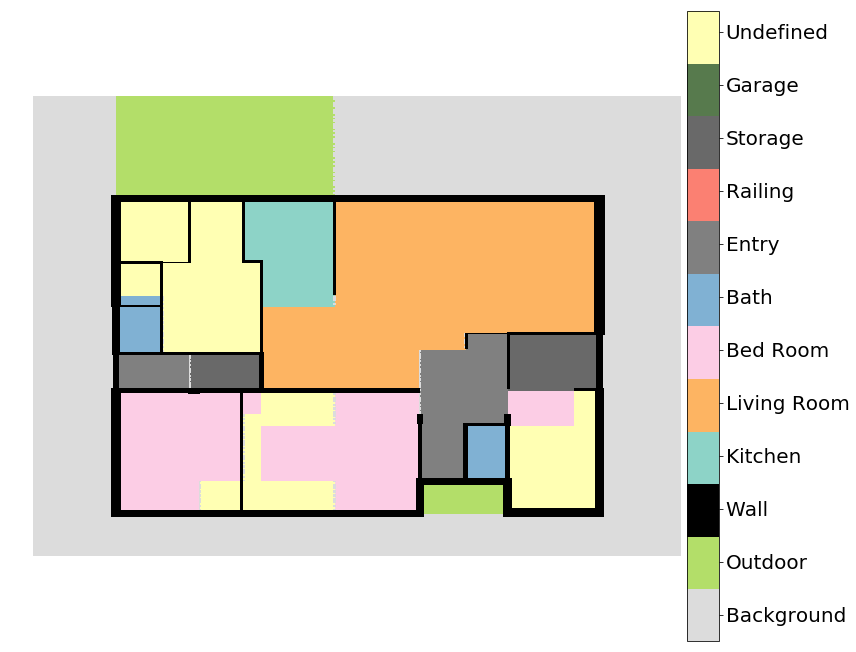

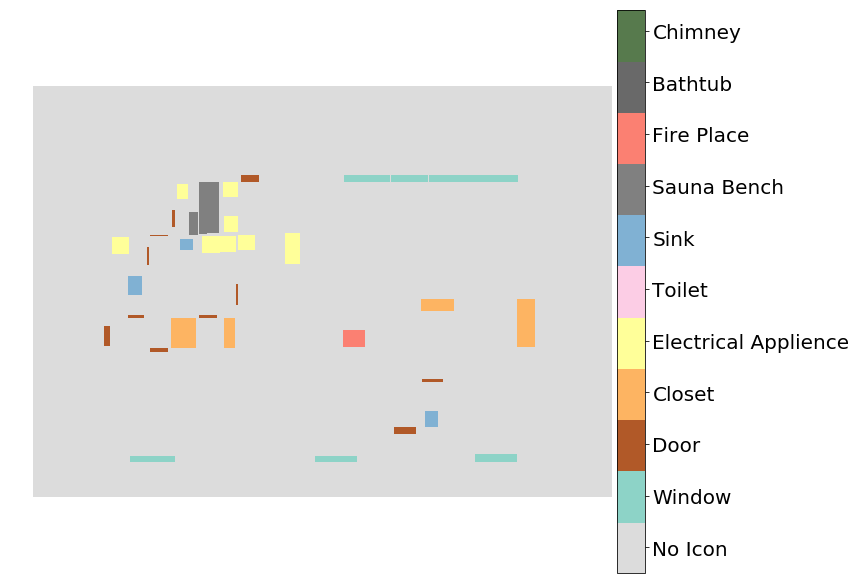

In [65]:

heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types, wall_lines, wall_points = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

print("wall Lines")
print(wall_lines)
print("wall_points")
print(wall_points)

pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)
plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.tight_layout()
plt.show()

## Ground truth and prediction comparisons

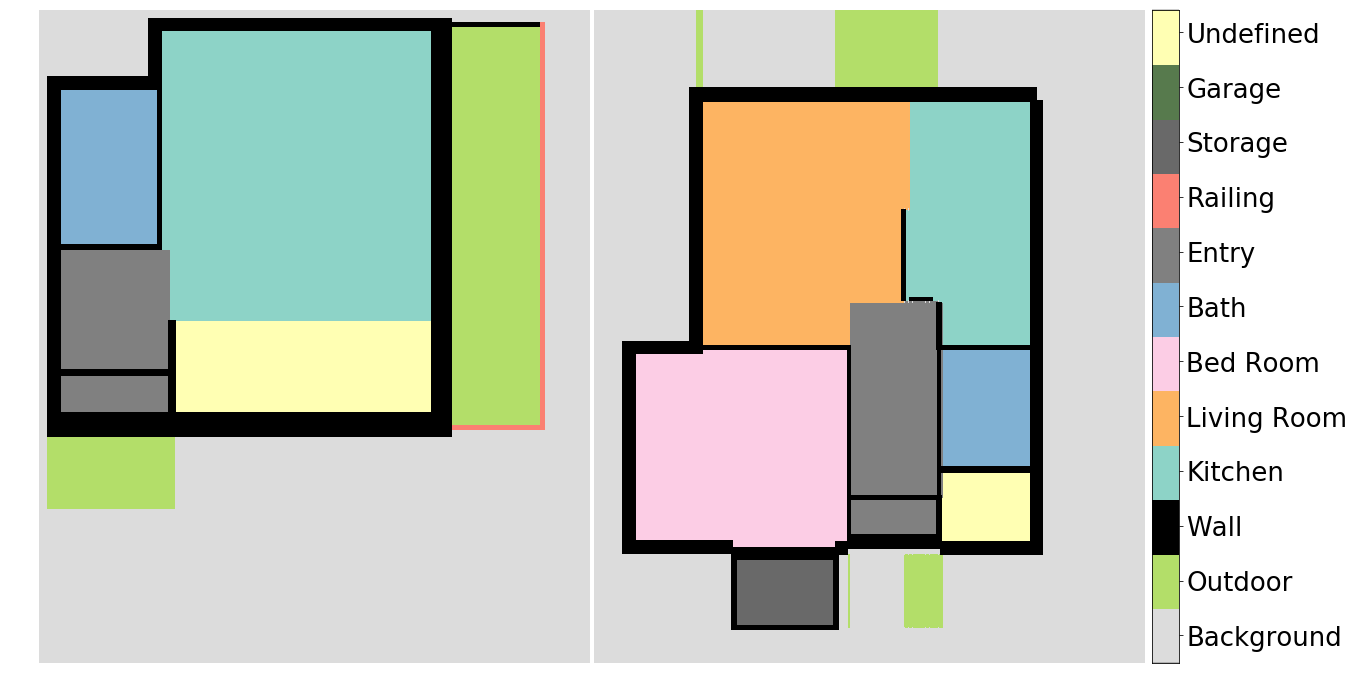

In [10]:
fig = plt.figure(figsize=(26, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 2),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
images = [label_np[0], pol_room_seg]
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(images[i], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = ax.cax.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5)
cbar.ax.set_yticklabels(room_classes, fontsize=26)
plt.show()


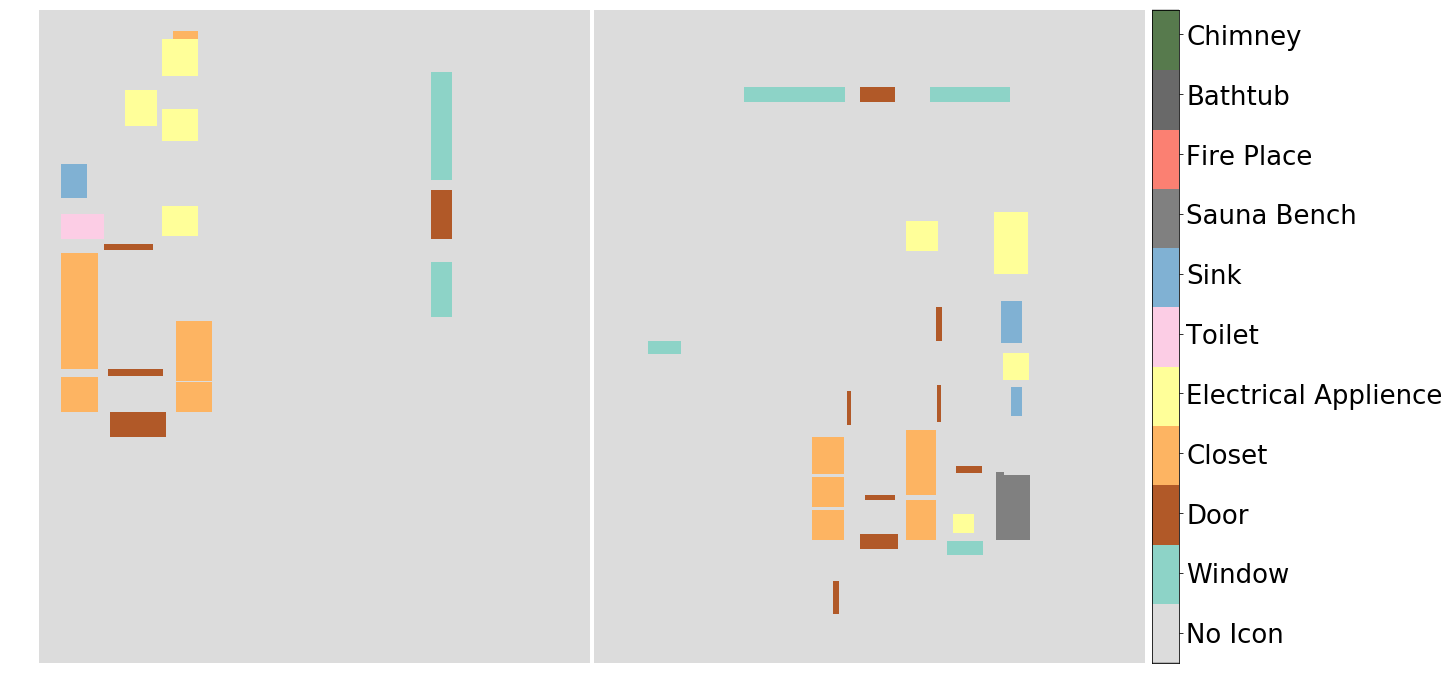

In [11]:
fig = plt.figure(figsize=(26, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 2),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

images = [label_np[1], pol_icon_seg]
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(images[i], cmap='icons', vmin=0, vmax=n_icons-0.1)

cbar = ax.cax.colorbar(iseg, ticks=np.arange(n_icons) + 0.5)
cbar.ax.set_yticklabels(icon_classes, fontsize=26)
plt.show()

In [12]:
def calculate_iou(pred, label, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        label_inds = (label == cls)
        intersection = np.logical_and(pred_inds, label_inds).sum()
        union = np.logical_or(pred_inds, label_inds).sum()
        if union == 0:
            ious.append(float('nan'))  # Ignore this class if it's not present in both pred and label
        else:
            iou = intersection / union
            ious.append(iou)
    return np.nanmean(ious)

def calculate_pixel_accuracy(pred, label):
    correct = (pred == label).sum()
    total = label.size
    return correct / total

# Beispiel Labels und Vorhersagen
rooms_label = label_np[0]
icons_label = label_np[1]
walls_label = (rooms_label == 2)  # Klasse 2 entspricht den Wänden
doors_label = (icons_label == 2)  # Klasse 2 entspricht den Türen

# Vorhersagen für Räume und Ikonen
rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

# Vorhersagen für Wände und Türen
walls_pred = (rooms_pred == 2)  # Klasse 2 entspricht den Wänden
doors_pred = (icons_pred == 2)  # Klasse 2 entspricht den Türen

# Berechnung der IoU
iou_rooms = calculate_iou(rooms_pred, rooms_label, n_rooms)
iou_icons = calculate_iou(icons_pred, icons_label, n_icons)
iou_walls = calculate_iou(walls_pred, walls_label, 2)  # 2 Klassen: Wand und Nicht-Wand
iou_doors = calculate_iou(doors_pred, doors_label, 2)  # 2 Klassen: Tür und Nicht-Tür

# Berechnung der Pixel-Genauigkeit
pixel_acc_rooms = calculate_pixel_accuracy(rooms_pred, rooms_label)
pixel_acc_icons = calculate_pixel_accuracy(icons_pred, icons_label)
pixel_acc_walls = calculate_pixel_accuracy(walls_pred, walls_label)
pixel_acc_doors = calculate_pixel_accuracy(doors_pred, doors_label)

print("IoU ist eine gängige Metrik zur Bewertung der Genauigkeit von Segmentierungsvorhersagen.")
print("Sie berechnet das Verhältnis der Schnittmenge der vorhergesagten Segmente zu ihrer Vereinigungsmenge.")
print(f"IOU Rooms: {iou_rooms:.4f}")
print(f"IOU Icons: {iou_icons:.4f}")
print(f"IOU Walls: {iou_walls:.4f}")
print(f"IOU Doors: {iou_doors:.4f}")
print(f"Pixel Accuracy Rooms: {pixel_acc_rooms:.4f}")
print(f"Pixel Accuracy Icons: {pixel_acc_icons:.4f}")
print(f"Pixel Accuracy Walls: {pixel_acc_walls:.4f}")
print(f"Pixel Accuracy Doors: {pixel_acc_doors:.4f}")

IoU ist eine gängige Metrik zur Bewertung der Genauigkeit von Segmentierungsvorhersagen.
Sie berechnet das Verhältnis der Schnittmenge der vorhergesagten Segmente zu ihrer Vereinigungsmenge.
IOU Rooms: 0.0589
IOU Icons: 0.1160
IOU Walls: 0.4275
IOU Doors: 0.4929
Pixel Accuracy Rooms: 0.3047
Pixel Accuracy Icons: 0.8832
Pixel Accuracy Walls: 0.8329
Pixel Accuracy Doors: 0.9857
